## 1.7 Augmentation

이번 실습에서는 Augmentation에 대해서 알아보고자 합니다. 데이터가 적은 상황에서 성능을 향상시킬 수 있는 방법이다. 이번 실습에서는 가장 간단한 Augmentation 방법인 noise를 추가하는 방법에 대해서 알아보고자 합니다. 

In [1]:
import math
import random 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
seed = 2020
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape([-1, 28 * 28]) 
x_test = x_test.reshape([-1, 28 * 28])

m = np.random.randint(0, high=60000, size=1100, dtype=np.int64)
x_train = x_train[m]
y_train = y_train[m]

i = np.arange(1100)
np.random.shuffle(i)
x_train = x_train[i]
y_train = y_train[i]

x_valid = x_train[:100]
y_valid = y_train[:100]

x_train = x_train[100:]
y_train = y_train[100:]

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int32, [None])
training = tf.placeholder(tf.bool)

n_units = [28 * 28, 512, 512, 10]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)

Input Layer에 Gaussian Noise를 추가합니다. 

In [2]:
# if you don't want to use Gaussian noise, just type `layer = x`
layer = x + tf.cond(training, lambda: tf.random.normal(tf.shape(x), mean=0.0, stddev=50), lambda: tf.zeros_like(x))
for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        layer = tf.nn.tanh(layer)  
y_hat = layer

다시 다른 부분들은 이전 실습과 동일하게 진행해 줍니다.

In [3]:
def augment_data(dataset, dataset_labels, random_rotation=True, random_shear=True,
                 random_shift=True, random_zoom=True):
    '''
    [Argument]
    dataset -- input dataset, shape:(N, Height, Width, Channel)
    dataset_labels -- input dataset labels, shape: (N,)
    
    [Return]
    augmented dataset -- type: numpy array, shape:(N, 28*28)
    augmented labels -- type: numpy array, shape:(N,)
    '''  
    augmented_dataset = []
    augmented_labels = []

    for i in range (0, dataset.shape[0]):
        data_orig = dataset[i].reshape(28, 28, -1)
        augmented_dataset.append(data_orig)
        augmented_labels.append(dataset_labels[i])

        if random_rotation is True:
            tmp = tf.contrib.keras.preprocessing.image.random_rotation(data_orig, 30, row_axis=0, col_axis=1, channel_axis=2)
            augmented_dataset.append(tmp)
            augmented_labels.append(dataset_labels[i])
        if random_shear is True:
            tmp = tf.contrib.keras.preprocessing.image.random_shear(data_orig, 0.3, row_axis=0, col_axis=1, channel_axis=2)
            augmented_dataset.append(tmp)
            augmented_labels.append(dataset_labels[i])
        if random_shift is True:
            tmp = tf.contrib.keras.preprocessing.image.random_shift(data_orig, 0.3, 0.3, row_axis=0, col_axis=1, channel_axis=2)
            augmented_dataset.append(tmp)
            augmented_labels.append(dataset_labels[i])
        if random_zoom is True:
            tmp = tf.contrib.keras.preprocessing.image.random_zoom(data_orig, (0.9, 0.9), row_axis=0, col_axis=1, channel_axis=2)
            augmented_dataset.append(tmp)
            augmented_labels.append(dataset_labels[i])

    augmented_dataset = np.array(augmented_dataset).reshape(-1, 28*28)
    augmented_labels = np.array(augmented_labels)
           
    return augmented_dataset, augmented_labels

In [4]:
y_hot = tf.one_hot(y, 10)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)
loss = cross_entropy_loss

accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), tf.argmax(y_hat, 1)),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_ops):
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss)
    
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

max_valid_epoch_idx = 0
max_valid_accuracy = 0.0
final_test_accuracy = 0.0

x_train, y_train = augment_data(x_train, y_train, random_rotation=True, random_shear=True, random_shift=True, random_zoom=True)

for epoch_idx in range(1, 1000 + 1):
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train,
                training: True
            })
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train,
                training: False
            })
        
        valid_loss_value, valid_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_valid,
                y: y_valid,
                training: False
            })
            
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test,
                training: False
            })

        print(epoch_idx, '%.4f' % train_loss_value, '%.4f' % valid_loss_value, '%.4f' % test_loss_value, '%.4f' % train_accuracy_value, '%.4f' % valid_accuracy_value, '%.4f' % test_accuracy_value)
        
        if max_valid_accuracy < valid_accuracy_value:
            max_valid_accuracy = valid_accuracy_value 
            max_valid_epoch_idx = epoch_idx
            final_test_accuracy = test_accuracy_value
            
    # Early Stop
    if max_valid_epoch_idx + 100 < epoch_idx:
        break
        
print(final_test_accuracy)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

10 1.1479 0.5350 0.5337 0.6820 0.8400 0.8354
20 0.9493 0.4864 0.4311 0.7434 0.8400 0.8721
30 0.7896 0.4459 0.4134 0.7768 0.8600 0.8831
40 0.6621 0.3918 0.3647 0.8064 0.8500 0.8949
50 0.5632 0.3611 0.3424 0.8358 0.8600 0.8978
60 0.4786 0.3074 0.3095 0.8614 0.8800 0.9110
70 0.4052 0.3312 0.2898 0.8822 0.8700 0.9118
80 0.3355 0.3018 0.2708 0.9046 0.8900 0.9168
90 0.2824 0.2510 0.2586 0.9256 0.9500 0.9208
100 0.2405 0.2597 0.2500 0.9338 0.9000 0.9236
110 0.2016 0.2726 0.2410 0.9518 0.9200 0.9255
120 0.1661 0.2594 0.2316 0.9622 0.9100 0.9268
130 0.1375 0.2311 0.2248 0.9688 0.9300 0.9320
140 0.1096 0.2334 0.2237 0.9780 0.9300 0.9303
1

87.10% -> 90.39% 성능이 향상됨을 확인할 수 있습니다. 

### 연습문제

Q1. Gaussian Noise Level에 따라 어떻게 성능이 변화하는지 확인해봅시다.

Q2. Image rotation, shear, shift, zoom augmentation을 적용해봅시다. 여러가지 augmentation을 한번에 사용하였을 때 성능의 추가 향상이 있나요? 
    

Q3. Augmenation이 잘 동작하는지 matplotlib library를 사용하여 직접 이미지를 확인해봅시다.
    (original , rotation, shear, shift, zoom)


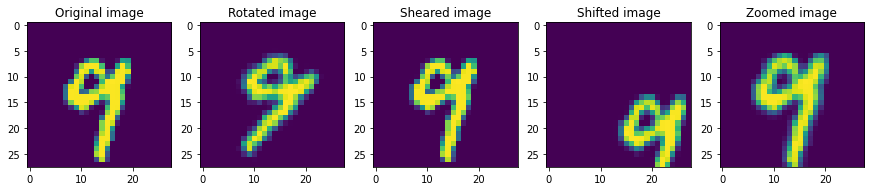

In [5]:
fig = plt.figure(figsize=(15,10))
plt.subplot(1,5,1)
plt.title('Original image')
plt.imshow(x_train[0].reshape((28, 28))) #TODO
plt.subplot(1,5,2)
plt.title('Rotated image')
plt.imshow(x_train[1].reshape((28, 28))) #TODO
plt.subplot(1,5,3)
plt.title('Sheared image')
plt.imshow(x_train[2].reshape((28, 28))) #TODO
plt.subplot(1,5,4)
plt.title('Shifted image')
plt.imshow(x_train[3].reshape((28, 28))) #TODO
plt.subplot(1,5,5)
plt.title('Zoomed image')
plt.imshow(x_train[4].reshape((28, 28))) #TODO

### Q2 HINT ###

***augment_data*** function 를 완성한 후, 적절한 cell에 넣어 사용하세요.

Augmentation를 위해 다음 함수들을 사용하시면 됩니다

**rotation** -- tf.contrib.keras.preprocessing.image.random_rotation()   
**shear**    -- tf.contrib.keras.preprocessing.image.random_shear()   
**shift**    -- tf.contrib.keras.preprocessing.image.random_shift()  
**zoom**     -- tf.contrib.keras.preprocessing.image.random_zoom()  

```python
def augment_data(dataset, dataset_labels, random_rotation=True, random_shear=True,
                 random_shift=True, random_zoom=True):
    '''
    [Argument]
    dataset -- input dataset, shape:(N, Height, Width, Channel)
    dataset_labels -- input dataset labels, shape: (N,)
    
    [Return]
    augmented dataset -- type: numpy array, shape:(N, 28*28)
    augmented labels -- type: numpy array, shape:(N,)
    '''  
    augmented_dataset = []
    augmented_labels = []

    for i in range (0, dataset.shape[0]):
       pass
           
    return augmented_dataset, augmented_labels
```


### Q3 Hint ###

```python
fig = plt.figure(figsize=(15,10))
plt.subplot(1,5,1)
plt.title('Original image')
plt.imshow() #TODO
plt.subplot(1,5,2)
plt.title('Rotated image')
plt.imshow() #TODO
plt.subplot(1,5,3)
plt.title('Sheared image')
plt.imshow() #TODO
plt.subplot(1,5,4)
plt.title('Shifted image')
plt.imshow() #TODO
plt.subplot(1,5,5)
plt.title('Zoomed image')
plt.imshow() #TODO
        
```